In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind,fisher_exact
import itertools as it
import networkx as nx
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})

In [2]:
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"

In [3]:
combinations_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
    ]


In [4]:
def get_merged_combo_file(combo_files):
    combo_dfs = [pd.read_csv(cf) for cf in combo_files]
    combo_df = pd.concat(combo_dfs)
    return combo_df

def get_case_samples_with_combos(combo_df):
    return set(sum(list(map(lambda v: v.split(","), combo_df.Case_Samples.values)), []))

In [5]:
combo_df = get_merged_combo_file(combinations_files)
case_samples = get_case_samples_with_combos(combo_df)

In [6]:
variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})

In [7]:
variants_df = variants_df.loc[variants_df.Sample.isin(case_samples)]

In [8]:
variants_df["SYMBOL"] = variants_df.SYMBOL.fillna(variants_df.Gene)

In [9]:
variant_type_dict = {"eid":[], "vtype":[], "combo":[]}

for uci,csamples in zip(combo_df.unique_combo_name, combo_df.Case_Samples):
    genes = uci.split("_")
    csamples = csamples.split(",")
    svdf = variants_df.loc[(variants_df.SYMBOL.isin(genes))&(variants_df.Sample.isin(csamples))]
    for group in svdf.groupby("Sample"):
        variant_type_dict["combo"].append(uci)
        variant_type_dict["eid"].append(group[0])
        variant_type_dict["vtype"].append("{" + ",".join([f'"{g}":"{mt}"'for g,mt in zip(group[1].SYMBOL, group[1].Mut_type)]) + "}")

In [10]:
variant_type_df = pd.DataFrame(variant_type_dict)

In [11]:
def construct_graph_from_df(combo_df):
    # create graph
    G = nx.Graph()
    # add nodes, edges, variant type to the graph
    for genes in combo_df.unique_combo_name.str.split("_"):
        for n1,n2 in it.combinations(genes, 2):
            G.add_edge(n1, n2)
    return G

In [12]:
gene_variant_graph = construct_graph_from_df(combo_df)

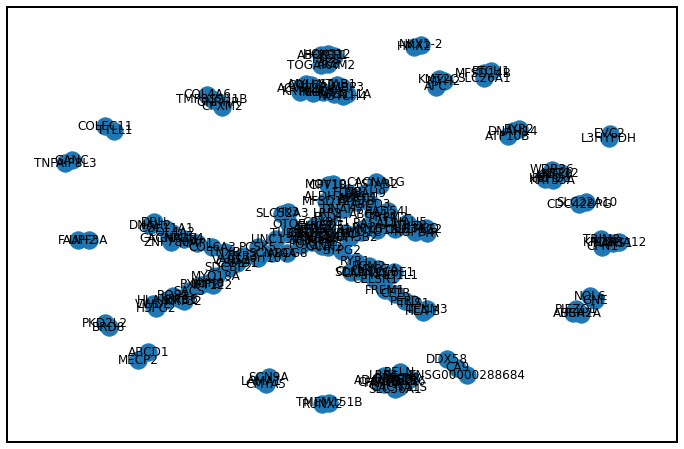

In [13]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
nx.draw_networkx(gene_variant_graph, pos=nx.spring_layout(gene_variant_graph), ax=ax)

In [14]:
def create_gene_to_variant_type_dict(variant_type_df):
    meta_vtype_dict = {}
    for vtype in variant_type_df.vtype:
        vtype_dict = json.loads(vtype)
        for k,v in vtype_dict.items():
            if k not in meta_vtype_dict:
                meta_vtype_dict[k] = {"missense":0, "lof":0}
                meta_vtype_dict[k][v] +=1
            else:
                meta_vtype_dict[k][v] +=1
    return meta_vtype_dict

In [15]:
gene_to_vtype_dict = create_gene_to_variant_type_dict(variant_type_df)

In [16]:
def create_contingency_table(gene_to_vtype_dict, high_degree_genes, low_degree_genes):
    hd_gene_counts = {"missense":0, "lof":0}
    ld_gene_counts = {"missense":0, "lof":0}
    for hd_gene in high_degree_genes:
        hd_gene_counts["missense"] += gene_to_vtype_dict[hd_gene]["missense"]
        hd_gene_counts["lof"] += gene_to_vtype_dict[hd_gene]["lof"]
    for ld_gene in low_degree_genes:
        ld_gene_counts["missense"] += gene_to_vtype_dict[ld_gene]["missense"]
        ld_gene_counts["lof"] += gene_to_vtype_dict[ld_gene]["lof"]

    data_dict = {
        "vtype": ["missense", "lof"],
        "low_degree": [ld_gene_counts["missense"], ld_gene_counts["lof"]],
        "high_degree": [hd_gene_counts["missense"], hd_gene_counts["lof"]],
        }
    return pd.DataFrame(data_dict).set_index("vtype")

In [17]:
degree_thresh = [1,2,3,4,5,6,7,8,9]
fishers_exact_scores = []

for dt in degree_thresh:
    high_degree_genes = [g for g in gene_variant_graph.nodes if gene_variant_graph.degree[g]>dt]
    low_degree_genes = [g for g in gene_variant_graph.nodes if not gene_variant_graph.degree[g]>dt]
    print(len(low_degree_genes), len(high_degree_genes))
    ctable = create_contingency_table(gene_to_vtype_dict, high_degree_genes, low_degree_genes)
    print(ctable)
    # Fisher's exact test under the null hypothesis that variant type and a combinatorial gene's degree are independent
    fishers_result = fisher_exact(ctable, alternative="less")
    print(fishers_result)
    fishers_exact_scores.append(fishers_result)

24 154
          low_degree  high_degree
vtype                            
missense         189         1510
lof               59          258
(0.5473341564709844, 0.0002553743863564958)
134 44
          low_degree  high_degree
vtype                            
missense         861          838
lof              218           99
(0.4665925861049681, 1.4114025859242446e-09)
139 39
          low_degree  high_degree
vtype                            
missense         933          766
lof              218           99
(0.5531355546506336, 2.4179792347359296e-06)
162 16
          low_degree  high_degree
vtype                            
missense        1246          453
lof              286           31
(0.2981367418453511, 2.694736244630773e-12)
165 13
          low_degree  high_degree
vtype                            
missense        1338          361
lof              286           31
(0.40173953470352364, 3.4967502220352586e-07)
173 5
          low_degree  high_degree
vtype                